In [2]:
main_dir = 'project_code/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)

## Functions

### analysis functions

In [7]:
import numpy as np
def get_norm_variance_across_stimuli(resp, istim):
    unique_istims = np.unique(istim)
    organized_data = []
    for stimulus in unique_istims:
        stimulus_indices = np.where(istim == stimulus)[0]
        stimulus_trials = resp[stimulus_indices]
        organized_data.append(stimulus_trials)
    
    organized_data = np.array(organized_data)
    
    # Calculate the mean and variance of responses for each stimulus and neuron
    mean_responses = np.mean(organized_data, axis=1)
    variance_responses = np.var(organized_data, axis=1)
    mean_variance_within_stimuli = np.mean(variance_responses, axis=0)
    variance_across_stimuli = np.var(mean_responses, axis=0)

    return variance_across_stimuli/(mean_variance_within_stimuli + 1e6)

import mouse_data_functions as cs
def get_norm_variance_all_mice(main_dir, mouse_stats):
    for dataset_type in ['natimg32','ori32']:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
        mousenames = list(mouse_stats[dataset_type].keys())
        for mouse in mousenames:
            mt.mt = mt.mts[mouse] 
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)
            istim = mt.istim
            mouse_stats[dataset_type][mouse]["L23"]['norm_variance'] = get_norm_variance_across_stimuli(resp_L23, istim)
            mouse_stats[dataset_type][mouse]['L4']['norm_variance'] = get_norm_variance_across_stimuli(resp_L4, istim)
                        

def reshape_resp(istim, resp, subsample = False, n_subsamples = 4, seed=17):
    unique_istims = np.unique(istim)
    reshaped_resps =[]
    for s, s_idx in enumerate(unique_istims):
        loc = np.where(istim==s_idx)[0]
        reshaped_resps.append(resp[loc])
    reshaped_resps=np.array(reshaped_resps)
    if subsample is True:
        indices = np.random.choice(np.arange(len(unique_istims), dtype=int), n_subsamples) 
        return reshaped_resps[indices]
    return reshaped_resps

from scipy import stats
def get_1_vs_rest_scsb(trial_no, reshaped_resp):
    # Compute means for both halves and all neurons at once
    x= reshaped_resp[:,trial_no]
    bulk_half = np.delete(reshaped_resp, trial_no, axis=1)
    y = np.nanmean(bulk_half, axis=1)
    
    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no corrections
    return correlations

from joblib import Parallel, delayed
def get_1_vs_rest_mouse(istim, resp,  subsample = False, n_subsamples = 4, seed=17):
    reshaped_resp= reshape_resp(istim, resp,  subsample, n_subsamples, seed)
    n_trials = reshaped_resp.shape[1]
    scsbs = []  # Initialize the results array
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_rest_scsb)(trial_no, reshaped_resp) for trial_no in range(n_trials))

    for sc in results:
        scsbs.append(sc)

    scsb=np.nanmean(np.array(scsbs), axis=0)
    return scsb

def get_1_vs_rest_all_mice(main_dir, mouse_stats, remove_pcs=False):
    rem_pc=''
    if remove_pcs is True:
        rem_pc='_removed_32_pcs'
    for dataset_type in ['natimg32','ori32']:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
        mousenames = list(mouse_stats[dataset_type].keys())
        for mouse in mousenames:
            mt.mt = mt.mts[mouse] 
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)
            istim = mt.istim
            mouse_stats[dataset_type][mouse]["L23"]['1_vs_rest_r'+ rem_pc] = get_1_vs_rest_mouse(istim, resp_L23)
            mouse_stats[dataset_type][mouse]['L4']['1_vs_rest_r'+ rem_pc] = get_1_vs_rest_mouse(istim, resp_L4)

In [128]:
### monkey

def get_1_vs_all_scsb_monkey_1trial(trial_no, binned_epochs):
    # Compute means for both halves and all neurons at once
    x= binned_epochs[trial_no]
    bulk_half = np.delete(binned_epochs, trial_no, axis=0)
    y = np.nanmean(bulk_half, axis=0)
    
    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no corrections

    return correlations

from joblib import Parallel, delayed

def get_1_vs_rest_r_monkey(binned_epochs):
    n_trials = len(binned_epochs)
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_all_scsb_monkey_1trial)(trial_no, binned_epochs) for trial_no in range(n_trials))
    scsbs = []
    for sc in results:
        scsbs.append(sc)
    scsb = np.mean(np.array(scsbs), axis=0)

    return scsb

def get_1_vs_all_scsb_monkey_RF_1trial(binned_labels, binned_epochs, trial_no, trial_avg=False):
    x, y = [],[]
    for cond_num in range(len(np.unique(binned_labels))):
        loc = np.argwhere(binned_labels==cond_num)[:, 0]
        x.append(binned_epochs[loc[trial_no]])
        y.append(np.nanmean(binned_epochs[np.delete(loc, trial_no)],axis=0))

    if trial_avg is True:
        x = np.array(x).mean(axis=1)
        y = np.array(y).mean(axis=1)
    else:
        x = np.concatenate(x, axis=0)
        y = np.concatenate(y, axis=0)

    correlations = np.array([stats.pearsonr(x[:,neuron], y[:,neuron])[0] for neuron in range(x.shape[1])])
    # no correction 
    return correlations

def get_min_trials(binned_labels):
    trial_nos=[]
    for cond_num in range(len(np.unique(binned_labels))):
        loc = np.argwhere(binned_labels==cond_num)[:, 0]
        trial_nos.append(len(loc))
    return min(trial_nos)

from macaque_data_functions import get_img_resp_avg_sem
def get_1_vs_rest_r_monkey_RF(resp_array, cond_labels, date, condition_type, trial_avg=False):
    scsbs = []

    binned_epochs = get_img_resp_avg_sem(resp_array, date, condition_type=condition_type, get_chunks=True)
    binned_labels = cond_labels[:,0,0]

    n_trials = get_min_trials(binned_labels)
    results = Parallel(n_jobs=-1)(delayed(get_1_vs_all_scsb_monkey_RF_1trial)(binned_labels, binned_epochs, trial_no, trial_avg) for trial_no in range(n_trials))

    for sc in results:
        scsbs.append(sc)
    
    return np.mean(np.array(scsbs), axis=0)

def get_dates(condition_type):
    if 'SNR' in condition_type or 'RS' in condition_type:
        return ['090817', '100817', '250717']
    elif 'large' in condition_type:
        return ['260617']
    else:
        return ['280617']


all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                    'RS_open':20, 'RS_closed': 20, 
                    'RF_thin':25, 'RF_large':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_open':None, 'RS_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200,'RF_large_spont':200}

condition_types =['SNR', 'SNR_spont', 'RS', 'RS_open', 'RS_closed', 'RF_thin', 'RF_large','RF_thin_spont','RF_large_spont']

from macaque_data_functions import get_get_condition_type, get_resps, get_img_resp_avg_sem
def get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25):
    area='V4'
    area2='V1'
    for dataset_type in ['RF_large','SNR','RF_thin']:
        dates = get_dates(dataset_type)
        for date in dates:
            if 'RF' in dataset_type:
                resp_V4, resp_V1, cond_labels =get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_off=all_ini_stim_offs[dataset_type], get_RF_labels=True)
                monkey_stats[dataset_type][date][area]['1_vs_rest_r']=get_1_vs_rest_r_monkey_RF(resp_V4, cond_labels, date, dataset_type)
                monkey_stats[dataset_type][date][area2]['1_vs_rest_r']=get_1_vs_rest_r_monkey_RF(resp_V1, cond_labels, date, dataset_type)
            else:
                resp_V4, resp_V1 =get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_off=all_ini_stim_offs[dataset_type])
                binned_epochs = get_img_resp_avg_sem(resp_V4, date, condition_type=dataset_type, get_chunks=True)  
                monkey_stats[dataset_type][date][area]['1_vs_rest_r']=get_1_vs_rest_r_monkey(binned_epochs)
                
                binned_epochs = get_img_resp_avg_sem(resp_V4, date, condition_type=dataset_type, get_chunks=True) 
                monkey_stats[dataset_type][date][area2]['1_vs_rest_r']=get_1_vs_rest_r_monkey(binned_epochs)

##### Functions for RF overlap interpredictability

In [182]:
import pandas as pd
def get_RF_filtered_df(monkey='L', date='250717', condition_type='SNR'):
    if 'RF' in condition_type:
        date = '250717'
    SNR_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_SNR_{date}_full.csv')
    area_mapping = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/channel_area_mapping_{monkey}.csv')
    SP = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_RS_{date}_removal_metadata.csv')
    overall_df = SNR_df.merge(area_mapping, on= ['Electrode_ID'])
    overall_df['SP_remove'] = overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])
    overall_df['SNR_remove'] = overall_df['SNR']<2
    overall_df['SP_SNR_remove'] = (overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])) | (overall_df['SNR']<2)
    RF_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/combined_{monkey}_RF.csv')
    RF_df_overall = overall_df.merge(RF_df, on = ['Electrode_ID', 'Array_ID', 'NSP_ID','within_NSP_electrode_ID', 'within_array_electrode_ID', 'Area'])
    RF_df_filtered = RF_df_overall[RF_df_overall.SP_SNR_remove==False]
    return RF_df_filtered

import math
def calculate_roi_properties(RF_df_overall, electrode_id):
    pixels_per_degree=25.8601
    rf_cell = RF_df_overall[RF_df_overall.Electrode_ID==electrode_id]
    roi_boundaries = rf_cell[['RF_left_edge (pixels)',
    'RF_right_edge (pixels)','RF_top_edge (pixels)',
    'RF_bottom_edge (pixels)']].values[0]/pixels_per_degree
    roi_center_x = (roi_boundaries[0] + roi_boundaries[1]) / 2
    roi_center_y = (roi_boundaries[2] + roi_boundaries[3]) / 2
    roi_width = roi_boundaries[1] - roi_boundaries[0]
    roi_height = roi_boundaries[3] - roi_boundaries[2]
    roi_size = math.sqrt(roi_width**2 + roi_height**2 )
    roi_theta_rad = math.atan2(roi_center_y, roi_center_x)
    roi_theta_deg = math.degrees(roi_theta_rad)
    
    return {
        'roi_center': (roi_center_x, roi_center_y),
        'roi_size': roi_size,
        'roi_theta': roi_theta_deg,
        'roi_width_height': (abs(roi_width), abs(roi_height))
    }
    
import math

from shapely.geometry import Point
from shapely import affinity
from shapely.geometry.polygon import Polygon as pol
from matplotlib import patches
import math

def get_overlap_percent_ellipse(RF_df_overall, ref_elec, other_elec):
    # Get properties of the ellipses
    roi_width1, roi_height1 = calculate_roi_properties(RF_df_overall, other_elec)['roi_width_height']
    roi_center_x1, roi_center_y1 = calculate_roi_properties(RF_df_overall, other_elec)['roi_center']

    roi_width2, roi_height2 = calculate_roi_properties(RF_df_overall, ref_elec)['roi_width_height']
    roi_center_x2, roi_center_y2 = calculate_roi_properties(RF_df_overall, ref_elec)['roi_center']

    if any(math.isnan(val) for val in [roi_width1, roi_height1,roi_center_x1, roi_center_y1,roi_width2, roi_height2,roi_center_x2, roi_center_y2]):
        return float('nan')

    
    ellipse1_ = patches.Ellipse(xy=(roi_center_x1, roi_center_y1), width=roi_width1, height=roi_height1, angle=0)
    ellipse2_ = patches.Ellipse(xy=(roi_center_x2, roi_center_y2), width=roi_width2, height=roi_width2, angle=0)

    coords1 = ellipse1_.get_verts()
    coords2 = ellipse2_.get_verts()
    ellipse1 = pol(coords1)
    ellipse2 = pol(coords2)


    # Compute intersection area
    intersect = ellipse1.intersection(ellipse2)
    overlap_area = intersect.area

    # Calculate the percentage of overlap
    overlap_percentage = (overlap_area / ellipse2.area) * 100
    if overlap_percentage > 100:
        overlap_percentage = 100

    return overlap_percentage

def get_overlap_indices(RF_df, ref_elec_id, overlap_indices, overlap_filt_elec_ids, seed=None, target_x_n=14, percent_over=60, percent_under=10):
    low_overlaps = []
    high_overlaps=[]
    for overlap_index, overlap_elec_ic in zip(overlap_indices, overlap_filt_elec_ids):
        percent = get_overlap_percent_ellipse(RF_df, ref_elec_id, overlap_elec_ic)
        if math.isnan(percent):
            continue
        if percent>percent_over:
            high_overlaps.append(overlap_index)
        if percent<percent_under:
            low_overlaps.append(overlap_index)
    
    if len(high_overlaps)<target_x_n or len(low_overlaps)<target_x_n:
        return float('nan'), float('nan')
    if seed is not None:
        np.random.seed(seed)
    high=np.random.choice(high_overlaps, size=target_x_n, replace=False)
    low= np.random.choice(low_overlaps, size=target_x_n, replace=False)
    return  high, low

In [198]:

def get_electrode_ids_all_dates(monkey_stats_):
    for condition_type in monkey_stats_:
        for date in monkey_stats_[condition_type]:
            df = get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
            for area in monkey_stats_[condition_type][date]:
                arrays = df[df['Area']==int(area[1:])]['Array_ID'].unique()
                elec_ids_area = []
                for array in arrays:
                    elec_ids_area.extend(df[df.Array_ID==array].sort_values(by='within_array_electrode_ID')['Electrode_ID'].values)
                has_RFs_area = []
                for elec in elec_ids_area:
                    roi_width1, roi_height1 = calculate_roi_properties(df, elec)['roi_width_height']
                    roi_center_x1, roi_center_y1 = calculate_roi_properties(df, elec)['roi_center']
                    has_RFs_area.append(not any(math.isnan(val) for val in [roi_width1, roi_height1,roi_center_x1, roi_center_y1]))
                monkey_stats_[condition_type][date][area]['Electrode_ID']=np.array(elec_ids_area)
                monkey_stats_[condition_type][date][area]['has_RF']=np.array(has_RFs_area)
                
def get_all_overlap_indices_elecids(RF_df, ref_elec_id, overlap_indices, overlap_filt_elec_ids, target_x_n=14, percent_over=60, percent_under=10):
    low_overlaps = []
    high_overlaps=[]
    low_overlap_elecs, high_overlap_elecs=[],[]
    for overlap_index, overlap_elec_ic in zip(overlap_indices, overlap_filt_elec_ids):
        percent = get_overlap_percent_ellipse(RF_df, ref_elec_id, overlap_elec_ic)
        if math.isnan(percent):
            continue
        if percent>percent_over:
            high_overlaps.append(overlap_index)
            high_overlap_elecs.append(overlap_elec_ic)
        if percent<percent_under:
            low_overlaps.append(overlap_index)
            low_overlap_elecs.append(overlap_elec_ic)
    high_overlaps=np.array(high_overlaps)
    high_overlap_elecs=np.array(high_overlap_elecs)
    low_overlaps=np.array(low_overlaps)
    low_overlap_elecs=np.array(low_overlap_elecs)

    return high_overlaps,high_overlap_elecs , low_overlaps,low_overlap_elecs

In [184]:
def get_filt_elec_ids_indices(monkey_stats, condition_type, date, area):
    elec_ids = monkey_stats[condition_type][date][area]['Electrode_ID']
    has_rfs = monkey_stats[condition_type][date][area]['has_RF']
    indices = [count for count, val in enumerate(has_rfs) if val]
    filt_elec_ids=elec_ids[indices]
    return indices, filt_elec_ids

def get_chosen_fil_elec_ids_indices(RF_df, ref_indices, ref_filt_elec_ids, other_indices, other_filt_elec_ids, target_x_n, percent_over, percent_under):
    chosen_ref_filt_elec_ids = []
    chosen_ref_indices = []
    for i, elec_id in zip(ref_indices, ref_filt_elec_ids):
        high, low  = get_overlap_indices(RF_df, elec_id, other_indices, other_filt_elec_ids, seed=0, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under)
        #basically keeps track of all the target electrodes that satisfy both under and overlap conditions, along with the number of predictors
        if type(high) != float:
            chosen_ref_filt_elec_ids.append(elec_id)
            chosen_ref_indices.append(i)
    return chosen_ref_indices, chosen_ref_filt_elec_ids

In [185]:
import random
num_seeds = 10
random.seed(17)
# Create a list of random seeds
seeds = [random.randint(1, 10000) for _ in range(num_seeds)]

In [187]:
def get_predictor_indices_elec_ids(monkey_stats, condition_type, get_condition_type, target_x_n=14, percent_over=80, percent_under=10):
    area='V4'
    area2='V1'
    dates= monkey_stats[condition_type].keys()
    for date in dates:
        RF_df= get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
        v4_indices,v4_filt_elec_ids=get_filt_elec_ids_indices(monkey_stats, condition_type,date, area)
        v1_indices,v1_filt_elec_ids=get_filt_elec_ids_indices(monkey_stats, condition_type, date,area2)
        chosen_v4_indices,chosen_v4_elec_ids = get_chosen_fil_elec_ids_indices(RF_df, v4_indices, v4_filt_elec_ids, v1_indices, v1_filt_elec_ids, target_x_n, percent_over, percent_under)
        chosen_v1_indices,chosen_v1_elec_ids = get_chosen_fil_elec_ids_indices(RF_df, v1_indices, v1_filt_elec_ids, v4_indices, v4_filt_elec_ids, target_x_n, percent_over, percent_under)

        monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']=(chosen_v4_indices,chosen_v4_elec_ids)
        monkey_stats[condition_type][date][area2][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']=(chosen_v1_indices,chosen_v1_elec_ids)

        results_v4 = Parallel(n_jobs=-1)(delayed(get_all_overlap_indices_elecids)(RF_df, v4_filt_elec_id, v1_indices, v1_filt_elec_ids, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under) for v4_filt_elec_id in chosen_v4_elec_ids)
        results_v1 = Parallel(n_jobs=-1)(delayed(get_all_overlap_indices_elecids)(RF_df, v1_filt_elec_id, v4_indices, v4_filt_elec_ids, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under) for v1_filt_elec_id in chosen_v1_elec_ids)

        v4_predictor_dict={}
        for v_idx, v_elec, predictors in zip(chosen_v4_indices,chosen_v4_elec_ids,results_v4):
            v4_predictor_dict[(v_idx, v_elec)]={}
            v4_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']=predictors[0]
            v4_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']=predictors[1]
            v4_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']=predictors[2]
            v4_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']=predictors[3]

        v1_predictor_dict={}
        for v_idx, v_elec, predictors in zip(chosen_v1_indices,chosen_v1_elec_ids,results_v1):
            v1_predictor_dict[(v_idx, v_elec)]={}
            v1_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']=predictors[0]
            v1_predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']=predictors[1]
            v1_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']=predictors[2]
            v1_predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']=predictors[3]
        
        monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']=v4_predictor_dict
        monkey_stats[condition_type][date][area2][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']=v1_predictor_dict


In [188]:
def get_predictors_elecs_seeds(RF_df, v_idx, v_elec, predictor_dict, seeds, target_x_n, percent_over, percent_under):
    high_is =predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']
    high_elecs=predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']
    low_is=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']
    low_elecs=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']

    indices_high=np.arange(len(high_elecs), dtype=int)
    indices_low = np.arange(len(low_elecs), dtype=int)

    elecs_5s = np.zeros([len(seeds),target_x_n ])
    elecs_60s = np.zeros_like(elecs_5s)
    indices_lows=np.zeros_like(elecs_5s)
    indices_highs=np.zeros_like(elecs_5s)

    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        np.random.shuffle(indices_high)
        np.random.shuffle(indices_low)
        elecs_5s[s]=low_elecs[indices_low[:target_x_n]]
        elecs_60s[s]=high_elecs[indices_high[:target_x_n]]
        indices_lows[s]=low_is[indices_low[:target_x_n]]
        indices_highs[s]=high_is[indices_high[:target_x_n]]

    return indices_lows, elecs_5s, indices_highs,elecs_60s

In [189]:
from joblib import Parallel, delayed
def get_neuron_RF_sizes_seed(RF_df, ref_elec_id, rf_sizes_low, rf_sizes_high, seed, target_x_n=14, percent_over=60, percent_under=10):
    np.random.seed(seed)
    indices_high=np.arange(len(rf_sizes_high))
    indices_low = np.arange(len(rf_sizes_low))
    np.random.shuffle(indices_high)
    np.random.shuffle(indices_low)
    return rf_sizes_low[indices_low[:target_x_n]], rf_sizes_high[indices_high[:target_x_n]]

In [190]:
def get_predictors_rf_sizes_seeds(RF_df, v_idx, v_elec, predictor_dict, seeds, target_x_n, percent_over, percent_under):
    
    high_is =predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_indices']
    high_elecs=predictor_dict[(v_idx, v_elec)][f'over_{percent_over}_pred_elec_ids']
    low_is=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_indices']
    low_elecs=predictor_dict[(v_idx, v_elec)][f'under_{percent_under}_pred_elec_ids']
    
    rf_sizes_high = RF_df[RF_df['Electrode_ID'].isin(high_elecs)]['RF size (degrees)'].values[np.argsort(high_elecs)]
    rf_sizes_low = RF_df[RF_df['Electrode_ID'].isin(low_elecs)]['RF size (degrees)'].values[np.argsort(low_elecs)]

    RF_sizes5s = np.zeros([len(seeds),target_x_n ])
    RF_sizes60s = np.zeros_like(RF_sizes5s) 

    results = Parallel(n_jobs=-1)(delayed(get_neuron_RF_sizes_seed)(RF_df,v_elec, rf_sizes_low, 
                                                                    rf_sizes_high, seed=seed, target_x_n=target_x_n,
                                                                    percent_over=percent_over, percent_under=percent_under)for seed in seeds)
    for s, (size5,size60) in enumerate(results):
        RF_sizes5s[s]=size5
        RF_sizes60s[s]=size60
    return RF_sizes5s,RF_sizes60s

In [191]:
def get_predictor_RF_sizes(monkey_stats, condition_type, get_condition_type, seeds, ref_area, target_x_n=14, percent_over=80, percent_under=10):
    area='V4'
    area2='V1'
    dates= monkey_stats[condition_type].keys()
    for date in dates:
        RF_df= get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
        chosen_indices,chosen_elec_ids = monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
        predictor_dict =monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']
        
        all_RF_sizes_low= np.zeros([len(chosen_indices), len(seeds), target_x_n])
        all_RF_sizes_high=np.zeros_like(all_RF_sizes_low)

        for i in range(len(chosen_indices)):
            all_RF_sizes_low[i],all_RF_sizes_high[i]= get_predictors_rf_sizes_seeds(RF_df=RF_df, v_idx=chosen_indices[i], v_elec=chosen_elec_ids[i], predictor_dict=predictor_dict, seeds=seeds, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under)

        monkey_stats[condition_type][date][ref_area][f'predictor_sizes_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=all_RF_sizes_low
        monkey_stats[condition_type][date][ref_area][f'predictor_sizes_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=all_RF_sizes_high



In [192]:
def get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_condition_type, seeds, ref_area, target_x_n=14, percent_over=80, percent_under=10):
    area='V4'
    area2='V1'
    dates= monkey_stats[condition_type].keys()
    for date in dates:
        RF_df= get_RF_filtered_df(monkey='L', date=date, condition_type=condition_type)
        chosen_indices,chosen_elec_ids = monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
        predictor_dict =monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_predictors_dict']
        
        all_elecs_low= np.zeros([len(chosen_indices), len(seeds), target_x_n])
        all_elecs_high=np.zeros_like(all_elecs_low)
        all_indices_low=np.zeros_like(all_elecs_low)
        all_indices_high=np.zeros_like(all_elecs_low)

        for i in range(len(chosen_indices)):
            all_indices_low[i],all_elecs_low[i],all_indices_high[i],all_elecs_high[i] = get_predictors_elecs_seeds(RF_df=RF_df, v_idx=chosen_indices[i], v_elec=chosen_elec_ids[i], predictor_dict=predictor_dict, seeds=seeds, target_x_n=target_x_n, percent_over=percent_over, percent_under=percent_under)

        monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=(all_indices_low,all_elecs_low)
        monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=(all_indices_high,all_elecs_high)



In [193]:
from ridge_regression_functions import get_best_alpha_evars
def process_neuron(ref_resp_cell, overlap_resp, indices_under_seed, indices_over_seed, frames_to_reduce, n_splits=10, control_shuffle=False):
    indices_under_seed_=[int(val) for val in indices_under_seed]
    indices_over_seed_=[int(val) for val in indices_over_seed]
    
    # print('over before', indices_over_seed, 'over after', indices_over_seed_)
    _, evars_high = get_best_alpha_evars(overlap_resp[:,indices_over_seed_], ref_resp_cell, n_splits=n_splits, frames_reduced=frames_to_reduce,control_shuffle=control_shuffle )
    _, evars_low = get_best_alpha_evars(overlap_resp[:,indices_under_seed_], ref_resp_cell, n_splits=n_splits, frames_reduced=frames_to_reduce,control_shuffle=control_shuffle)
    return evars_low[0], evars_high[0]

In [194]:
def get_over_under_evar_seeds(ref_resp_cell, overlap_resp, indices_under, indices_over, n_seeds=10, frames_to_reduce=5, n_splits=10, control_shuffle=False):

    evars_under = np.zeros([n_seeds])
    evars_over = np.zeros_like(evars_under) 
    
    results = Parallel(n_jobs=-1)(delayed(process_neuron)(ref_resp_cell, overlap_resp, indices_under[s], indices_over[s], frames_to_reduce, n_splits=n_splits, control_shuffle=control_shuffle) for s in range(n_seeds))

    for s, (evar_under,evar_over) in enumerate(results):
        evars_under[s]=evar_under
        evars_over[s]=evar_over
    return evars_under,evars_over

In [196]:
from macaque_data_functions import get_resps
import copy
def get_x_target_overlap_evars(monkey_stats, condition_type, get_condition_type, seeds, 
                               ref_area, target_x_n=14, percent_over=80, percent_under=10, 
                               w_size=25, stim_on=0, stim_off=400, frames_to_reduce=5, 
                               n_splits=10, control_shuffle=False, seed_=17):

    dates= monkey_stats[condition_type].keys()
    
    for date in dates:
        resp_V4, resp_V1 =get_resps(condition_type=get_condition_type, date=date, w_size=w_size, stim_on=stim_on, stim_off=stim_off)

        if ref_area=="V4":
            ref_resp=resp_V4
            overlap_resp=resp_V1
            overlap_area='V1'
        else:
            ref_resp=resp_V1
            overlap_resp=resp_V4
            overlap_area='V4'
                    
        chosen_indices,chosen_elec_ids = monkey_stats[condition_type][date][ref_area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
        
        _,seeds_elecs_under =monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']
        _, seeds_elecs_over = monkey_stats[condition_type][date][ref_area][f'predictor_target_indices_elecs_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']
        n_seeds=seeds_elecs_under.shape[1]
        ref_elec_ids = monkey_stats[condition_type][date][overlap_area]['Electrode_ID']

        seeds_indices_under=np.zeros_like(seeds_elecs_under)
        seeds_indices_over= np.zeros_like(seeds_elecs_under)

        for neuron in range(len(chosen_indices)):
            for s in range(n_seeds):
                seeds_indices_under[neuron,s]=np.array([count for count,val in enumerate(ref_elec_ids) if val in seeds_elecs_under[neuron, s]])
                seeds_indices_over[neuron,s]=np.array([count for count,val in enumerate(ref_elec_ids) if val in seeds_elecs_over[neuron,s]])
                # print('under', np.max(seeds_indices_under[neuron,s]))
                # print('under', np.max(seeds_indices_over[neuron,s]))

        evars_under= np.zeros([len(chosen_indices), len(seeds)])
        evars_over=np.zeros_like(evars_under)
        
        results = Parallel(n_jobs=-1)(delayed(get_over_under_evar_seeds)(ref_resp[:,chosen_indices[i]], overlap_resp, seeds_indices_under[i], 
                                                                         seeds_indices_over[i], n_seeds, frames_to_reduce, n_splits,
                                                                         control_shuffle=control_shuffle) for i in range(len(chosen_indices)))

        for i, (ev_under, ev_over) in enumerate(results):
            evars_under[i]=ev_under
            evars_over[i]=ev_over

        if control_shuffle is True:
            monkey_stats[condition_type][date][ref_area][f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null']=evars_under
            monkey_stats[condition_type][date][ref_area][f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null']=evars_over
        else:
            monkey_stats[condition_type][date][ref_area][f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=evars_under
            monkey_stats[condition_type][date][ref_area][f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}']=evars_over


### plotting functions

In [374]:
import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_neuron_properties(mouse_stats_, dataset_types=['ori32','natimg32'], remove_pcs=False):
    rem_pc = ''
    if remove_pcs is True:
        rem_pc='_removed_32pcs'
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r' + rem_pc]
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                variances = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['norm_variance']
                one_vs_rests = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['1_vs_rest_r'+ rem_pc]
                if act_type == 'gray screen':
                    rem_pc_ = '' # did not to inter area predictability removing 32pcs of spont for gray screen activity 
                else:
                    rem_pc_ = rem_pc
                for n, (split_half_r, snr,max_corr_val, var, onevsrest, evar, null_evar) in enumerate(zip(split_half_rs, SNRs,values['max_corr_val'+ rem_pc_],variances, one_vs_rests, values['evars'+ rem_pc_],values['evars_null'])):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'variance':var,
                        'control_shuffle':False, 
                        'Neuron':n
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'variance':var,
                        'control_shuffle':True,
                        'Neuron':n 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df_neuron_properties(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif dataset_type=='RS':
            act_type = 'lights off'
        elif dataset_type =='RS_open':
            act_type = 'lights off\neyes open'
        elif dataset_type =='RS_closed':
            act_type = 'lights off\neyes closed'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                one_vs_rests = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['1_vs_rest_r']
                evars = values['evars']
                evars_null = values['evars_null']
                
                for split_half_r, snr,max_corr_val,onevsrest, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],one_vs_rests,evars,evars_null):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [34]:
def perm_test(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group1) - np.nanmean(group2)
    # Number of permutations to perform
    num_permutations = 10000
    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)
    # Combine the data from both groups
    combined_data = np.concatenate((group1, group2))
    # Perform the permutation test
    for i in range(num_permutations):
        # Randomly shuffle the combined data
        np.random.shuffle(combined_data)
    
        # Split the shuffled data back into two groups
        permuted_group1 = combined_data[:len(group1)]
        permuted_group2 = combined_data[len(group1):]
        
        # Calculate the test statistic for this permutation
        permuted_statistic = np.nanmean(permuted_group1) - np.nanmean(permuted_group2)
        
        # Store the permuted test statistic
        permuted_statistics[i] = permuted_statistic

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

def perm_test_paired(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group2-group1)

    # Number of permutations to perform
    num_permutations = 10000

    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Combine the differences
    pooled_differences = group2-group1
    
    # Perform the permutation test
    for i in range(num_permutations):
        # shuffle differences
        permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
        
        # Recalculate mean difference for the permuted dataset
        permuted_mean_difference = np.nanmean(permuted_differences)
    
        # Store the permuted mean difference
        permuted_statistics[i] = permuted_mean_difference

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

# Function to perform hierarchical permutation test with animal bootstrapping
def hierarchical_permutation_test(data, mouse_or_date, dependent_variable, neuron_property,perm_type='ind', num_permutations=1000):
    observed_statistic = calculate_statistic(data, dependent_variable, neuron_property, perm_type)  # Replace with your actual calculation

    # Create an empty array to store permuted statistics
    permuted_statistics = np.zeros(num_permutations)

    # Iterate through each permutation
    for i in range(num_permutations):
        # Bootstrap animals (resample entire animals with replacement)
        bootstrap_animals_or_dates = np.random.choice(data[mouse_or_date].unique(), size=len(data[mouse_or_date].unique()), replace=True)
        data2 = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
        if 'Mouse' in mouse_or_date:
        # bootstrapped_data = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
            min_cells_per_mouse = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby(['Mouse',dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_mouse, replace=False) for _, group_ in data2.groupby(['Mouse',dependent_variable])])
        else:
            min_cells_per_date = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby([mouse_or_date,dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_date, replace=False) for _, group_ in data2.groupby([mouse_or_date,dependent_variable])])

        if perm_type =='ind':
            # Permute values within each bootstrapped animal
            for animal in bootstrapped_data[mouse_or_date].unique():
                animal_values = bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property].values
                np.random.shuffle(animal_values)
                bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property] = animal_values
            # Calculate the permuted statistic
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type)
        elif perm_type =='paired':
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type, paired_shuffle=True)
        # Store the permuted statistic
        permuted_statistics[i] = permuted_statistic
    # Calculate the p-value
    p_value = np.mean(np.abs(permuted_statistics) >= np.abs(observed_statistic))
    return p_value

# Example function for the statistic of interest
def calculate_statistic(data, group, neuron_property, perm_type='ind', paired_shuffle=False):
    groups = data[group].unique()
    if perm_type =='ind':
        mean_group_a = data[data[group] == groups[0]][neuron_property].mean()
        mean_group_b = data[data[group] == groups[1]][neuron_property].mean()
        return mean_group_a - mean_group_b
    elif perm_type =='paired':
        if data[data[group] == groups[0]][neuron_property].size != data[data[group] == groups[1]][neuron_property].size:
            print('sizes are not the same, you should not used a paired permutation test here')
            print(data[data[group] == groups[0]][neuron_property].size,data[data[group] == groups[1]][neuron_property].size)
        pooled_differences = data[data[group] == groups[0]][neuron_property].values-data[data[group] == groups[1]][neuron_property].values
        if paired_shuffle is True:
            permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
            # Recalculate mean difference for the permuted dataset
            return np.nanmean(permuted_differences)
        else:
            return np.nanmean(pooled_differences)


from scipy import stats
def get_t_test_stars(df_, dependent_variable, neuron_property, print_pval=False, 
                    perm_t=True, perm_type='ind', hierarchical=False, num_permutations=1000,mouse_or_date='Mouse Name'):
    
    variables = df_[dependent_variable].unique()
    group_1 =df_[df_[dependent_variable]==variables[0]][neuron_property].dropna().values
    group_2 =df_[df_[dependent_variable]==variables[1]][neuron_property].dropna().values
    
    if hierarchical is True:
        p_value = hierarchical_permutation_test(df_,mouse_or_date=mouse_or_date, 
                                        dependent_variable=dependent_variable, 
                                        neuron_property=neuron_property,
                                        perm_type=perm_type,num_permutations=num_permutations)
    
    elif perm_type=='paired':
        p_value = perm_test_paired(group_1, group_2)
    elif perm_t is True:
        p_value = perm_test(group_1, group_2)
    elif perm_type=='ind':
        _, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)
    else:
        print('perm_type must be either ind or paired')
        return np.nan
    if p_value <1e-3:
        stars = '***'
    elif p_value <1e-2:
        stars = '**'
    elif p_value <0.05:
        stars='*'
    else:
        stars='n.s.'
    if print_pval is True:
        print(p_value)
    return stars

def add_stars_2_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, height1=0.97, height2=0.97, perm_t=True, perm_type='ind', hierarchical=False, mouse_or_date='Mouse Name'):
    stars1 = get_t_test_stars(df_[df_[x]==x_order[0]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type, hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    stars2 = get_t_test_stars(df_[df_[x]==x_order[1]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type,hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    if stars1 == 'n.s.':
        height1 = height1 + 0.02
        fontsize1 = fontsize*0.9
        color1='#C0C0C0'
    else:
        fontsize1 = fontsize
        color1='black'
        
    if stars2 == 'n.s.':
        height2 = height2 + 0.02
        fontsize2 = fontsize*0.9
        color2='#C0C0C0'
    else:
        fontsize2 = fontsize
        color2='black'
    
    ax.text(0.25, height1, stars1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
    ax.text(0.75, height2, stars2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)

In [37]:
from scipy.stats import pearsonr
def make_corr_df_mouse(mouse_stats_, df_, value_types =['EV','max r² val', '1-vs-rest r²','SNR', 'variance', 'split-half r'] ):
    neuron_property='EV'
    data = []
    for dataset_type in mouse_stats_:
        for mouse in mouse_stats_[dataset_type]:
            for area in mouse_stats_[dataset_type][mouse]:
                if area=='L23':
                    area = 'L2/3'
                sub_df = df_[(df_['Dataset Type'] ==dataset_type)&(df_.Area==area)&(df_.Mouse==mouse)].reset_index()
                for value_type in value_types:
                    data.append({
                        'Dataset Type':dataset_type,
                        'Mouse': mouse,
                        'Area': area,
                        'Value_Type':value_type,
                        'Ref_property': neuron_property,
                        'relationship':f'{neuron_property}_{value_type}',
                        'Activity Type':sub_df['Activity Type'].unique()[0],
                        'corr': sub_df[neuron_property].corr(sub_df[value_type]),
                        'corr_pval': pearsonr(sub_df.dropna()[neuron_property].values, sub_df.dropna()[value_type].values)[1]
                    })
    df_mouse_corr = pd.DataFrame(data) 
    return df_mouse_corr

import seaborn as sns
def set_corr_figs_params(ax, fontsize=6):
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('corr w/ EV fraction', fontsize=fontsize, labelpad=0)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
    ax.legend(fontsize=fontsize*0.8).get_frame().set_linewidth(0.2)
    ax.spines[:].set_linewidth(0.5)
    sns.despine()
    
def add_stars_5_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, heights=None, x_positions=None):
    if x_positions is None:
        x_positions = [0.1,0.3,0.51,0.71,0.91]
    if heights is None:
        heights = np.ones([5])*0.97
    
    for s, xtick_label in enumerate(x_order):
        star =get_t_test_stars(df_[df_[x]==xtick_label], hue, neuron_property)
        if star =='n.s.':
            height_=heights[s]+0.015
            color='#C0C0C0'
        else:
            height_=heights[s]
            color='black'
        ax.text(x_positions[s], height_, star, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes, color=color)


In [46]:
def plot_mouse(df_, area, neuron_property, ax, y='EV', alpha=0.8, markersize=8,fontsize=6,r_pos = (0.05,0.95), **args):
    area_query=f'Area=="{area}"'

    if area=='L2/3':
        color= '#72BEB7'
        line_color = 'darkcyan'
    else:
        color= '#E79090'
        line_color='#94221F'
    sns.scatterplot(df_.query(area_query), x=neuron_property, 
    y=y, color=color, ax=ax, alpha=alpha, s=markersize, **args)

    # Calculate the correlation
    correlation = df_.query(area_query)[neuron_property].corr(df_.query(area_query)[y])
    sns.despine()

    ax.text(r_pos[0], r_pos[1], f'r={correlation:.2f}',fontsize=fontsize, transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, pad=1)
    ax.set_xlabel(neuron_property, fontsize=fontsize, labelpad=0)
    ax.spines[:].set_linewidth(0.5)
    return f'{correlation:.2f}'

In [101]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
colors = ['#ddf2f0', '#55C0B7', '#112624']
norm = Normalize(vmin=0, vmax=1)
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
colors = ['#FFE8E8', '#F58B8E', '#551312']
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

In [160]:
### monkey

def make_corr_df_monkey(monkey_stats_, df_):
    value_types=['EV','max r² val','1-vs-rest r²','SNR',
        'split-half r']
    neuron_property='EV'
    data = []
    for dataset_type in monkey_stats_:
        for date in monkey_stats_[dataset_type]:
            for area in monkey_stats_[dataset_type][date]:
                sub_df = df_[(df_['Dataset Type'] ==dataset_type)&(df_.Area==area)&(df_.Date==date)].reset_index()
                for value_type in value_types: 
                    data.append({
                        'Dataset Type':dataset_type,
                        'Date': date,
                        'Area': area,
                        'Value_Type':value_type,
                        'Ref_property': neuron_property,
                        'relationship':f'{neuron_property}_{value_type}',
                        'Activity Type':sub_df['Activity Type'].unique()[0],
                        'corr': sub_df[neuron_property].corr(sub_df[value_type])
                    })
    df_monkey_corr = pd.DataFrame(data) 
    return df_monkey_corr

def plot_bars(ax, heights=[1.1,1.2,1.3], x_position_left=-0.395, x_positions_right=[0.07,0.21,0.39]):
    ax.plot([x_position_left,x_positions_right[0]], # -0.095, units are width of the axes
        [heights[0], heights[0]], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.4)
    ax.plot([x_position_left,x_positions_right[1]], # -0.095, units are width of the axes
            [heights[1], heights[1]], # 0 to 500, units are same as the y-axis
            clip_on=False,
            transform=ax.get_xaxis_transform(),
            color='black', linewidth=0.4)
    ax.plot([x_position_left,x_positions_right[2]], # -0.095, units are width of the axes
            [heights[2], heights[2]], # 0 to 500, units are same as the y-axis
            clip_on=False,
            transform=ax.get_xaxis_transform(),
            color='black', linewidth=0.4)
    
def plot_4_bars(ax, heights=[1.1,1.2,1.3], x_position_left=-0.395, x_positions_right=[0.07,0.21,0.39]):
    plot_bars(ax, heights,x_position_left, x_positions_right)
    plot_bars(ax, heights,x_position_left+1, x_positions_right+1)
    plot_bars(ax, heights,x_position_left+2, x_positions_right+2)
    plot_bars(ax, heights,x_position_left+2, x_positions_right+2)

In [243]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations  # Import combinations from itertools with a different name

def get_one_way_anova_pstats(df, neuron_property, variable1, perm_t=False):
    df_posthoc = df.dropna().copy()
    # Perform pairwise t-tests with Benjamini-Hochberg correction
    groups = df_posthoc[f'{variable1}'].unique()
    p_values = []
    p_val_names = []

    for group1, group2 in combinations(groups, 2):
        group1_data = df_posthoc[df_posthoc[f'{variable1}'] == group1][neuron_property]
        group2_data = df_posthoc[df_posthoc[f'{variable1}'] == group2][neuron_property]
        
        if perm_t is True:
            p_value = perm_test(group1_data, group2_data)
        else:
            _, p_value = stats.ttest_ind(group1_data, group2_data)
        p_values.append(p_value)
        p_val_names.append(group1 + '_' + group2)

    # Apply Benjamini-Hochberg correction
    adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

    return p_val_names, adjusted_p_values
def get_oneway_anova_stars(df_, dependent_variable, neuron_property, perm_t=True):
    all_stars = []
    p_val_names, adjusted_p_values= get_one_way_anova_pstats(df_,neuron_property,dependent_variable,perm_t=perm_t)
    for name, p_value in zip(p_val_names, adjusted_p_values):
        if p_value <1e-3:
            stars = '***'
        elif p_value <1e-2:
            stars = '**'
        elif p_value <0.05:
            stars='*'
        else:
            stars='n.s.'
        all_stars.append(stars)
    return p_val_names, all_stars



def add_anova_stars_1_set_rf_overlap(df_, neuron_property,x,x1, hue, ax, 
                           fontsize=8, height1=0.92, height3=0.92, height2=0.99, 
                           stars1_positions= None, perm_t=True, bar_halflength = 0.05):
    df_x1 = df_[df_[x]==x1].reset_index()
    _,all_stars1 = get_oneway_anova_stars(df_x1, hue, neuron_property, perm_t=perm_t)
    height_positions = [height1, height2, height3]
    if stars1_positions is None:
        stars1_positions= [0.07,0.1,0.13]
    for s, star1 in enumerate(all_stars1):
        if s==1:
            ax.hlines(height_positions[s]- 0.01, stars1_positions[s] - bar_halflength, stars1_positions[s] + bar_halflength, color='black',linewidth=0.5,transform=ax.transAxes)
        if star1 =='n.s.':
            height_positions[s]=height_positions[s]+0.008
            fontsize_=fontsize*0.8
            color='#C0C0C0'
        else:
            fontsize_=fontsize
            color='black'
        ax.text(stars1_positions[s], height_positions[s], star1, ha='center', va='center', fontsize=fontsize_, transform=ax.transAxes,color=color)


def add_anova_stars_1_set(df_, neuron_property, x, x1, hue, ax, fontsize=5, height1=0.73, 
                           height2=0.82,height3=0.91, height4=1, stars1_positions=None, stars2_positions=None,
                           perm_t=True, show_bar=True, bar_halflength = 0.035):
    pval_names,all_stars1 = get_oneway_anova_stars(df_[df_[x]==x1], hue, neuron_property, perm_t=perm_t)
    height_positions1 = [height1,height2,height3,height4]
    if stars1_positions is None:
        stars1_positions= [0.14,0.19,0.23,0.27]
    
    offset_=0
    for s, (star1) in enumerate(all_stars1[:4]):
        if s>0:
            if show_bar is True:
                ax.hlines(height_positions1[s]- 0.015, stars1_positions[s] - bar_halflength-offset_, stars1_positions[s] + bar_halflength+offset_, 
                            color='black',transform=ax.transAxes, linewidth=0.5)
        if star1 =='n.s.':
            height_positions1[s]=height_positions1[s]+0.03
            fontsize_=fontsize*0.8
            color = '#C0C0C0'
        else:
            fontsize_=fontsize
            color='black'
        ax.text(stars1_positions[s], height_positions1[s], star1, ha='center', va='center', fontsize=fontsize_, transform=ax.transAxes, color=color)        
        offset_+=0.02 

In [158]:
from matplotlib import patches
def plot_corr_bars(df_monkey_corr, ax, area, remove_legend=True):
    order= df_monkey_corr.Value_Type.unique()[1:]
    filter_bool = df_monkey_corr['relationship'].isin(['EV_EV'])
    area_bool = df_monkey_corr['Area']==area
    mask = (~filter_bool)&area_bool
    if remove_legend is True:
        if area =='V4':
            palette=['#72BEB7','#B6E3DF','#136a66','#136a66','#136a66']
        elif area=='V1':
            palette=['#EDAEAE', '#f6d6d6','#a85959','#a85959','#a85959']
    else:
        palette = ['gray', 'lightgray','#3b3b3b','#3b3b3b','#3b3b3b']  
    hue_order= df_monkey_corr['Activity Type'].unique()
    
    sns.barplot(data=df_monkey_corr[mask], x='Value_Type', palette=palette,
                y='corr', order=order, hue='Activity Type', hue_order=hue_order,
                errorbar='se', gap=0.05, linewidth=0.5, err_kws={'linewidth': 1})
    bars  = [s for s in ax.get_children() if isinstance(s, patches.Rectangle)]
    lines = ax.get_lines()
    offset_val=0.02
    hatch_size=3
    for b, (bar, line) in enumerate(zip(bars, lines)):
        if b in [12,13,14,15]:
            bar.set_hatch('/'*hatch_size)
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
        elif b in [16,17,18,19]:
            bar.set_hatch('.'*hatch_size)
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
        if b in [8,9,10,11]:
            line.set_xdata(line.get_xdata()+offset_val)
            bar.set_x(bar.get_x()+offset_val)
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=0)
    ax.set_xlabel(None)
    ax.set_ylabel('corr w/ EV fraction', fontsize=6, labelpad=3, loc='bottom')
    ax.tick_params(axis='both', labelsize=6, width=0.3, length=2, pad=1)
    if remove_legend is True:
        ax.legend_.remove()
    ax.spines[:].set_linewidth(0.5)
    ax.set_ylim(0,1.45)
    sns.despine()
    return mask, order

In [168]:
def plot_date(df_, area, neuron_property, ax, alpha=0.8, y='EV', hue='EV gray screen', 
              r_loc =(0.05,0.95), s=8,fontsize=6, **args):
    area_query=f'Area=="{area}"'

    if area=='V4':
        color= '#72BEB7'
        line_color = 'darkcyan'
    else:
        color= '#E79090'
        line_color='#94221F'
    sns.scatterplot(df_.query(area_query), x=neuron_property, 
    y=y, color=color, ax=ax, hue=hue, alpha=alpha, s=s, **args)

    # Calculate the correlation
    correlation = df_.query(area_query)[neuron_property].corr(df_.query(area_query)[y])
    
    sns.despine()
    ax.text(r_loc[0], r_loc[1], f'r={correlation:.2f}',fontsize=fontsize, transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.5, pad=1)
    ax.set_xlabel(neuron_property, fontsize=fontsize, labelpad=1)
    ax.spines[:].set_linewidth(0.5)
    return f'{correlation:.2f}'

In [221]:
def get_RF_filtered_df(monkey='L', date='250717', condition_type='SNR'):
    if 'RF' in condition_type:
        date = '250717'
    SNR_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_SNR_{date}_full.csv')
    area_mapping = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/channel_area_mapping_{monkey}.csv')
    SP = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/{monkey}_RS_{date}_removal_metadata.csv')
    overall_df = SNR_df.merge(area_mapping, on= ['Electrode_ID'])
    overall_df['SP_remove'] = overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])
    overall_df['SNR_remove'] = overall_df['SNR']<2
    overall_df['SP_SNR_remove'] = (overall_df['Electrode_ID'].isin(SP['Removed electrode ID'])) | (overall_df['SNR']<2)
    RF_df = pd.read_csv(main_dir + f'data/chen/metadata/monkey_{monkey}/combined_{monkey}_RF.csv')
    RF_df_overall = overall_df.merge(RF_df, on = ['Electrode_ID', 'Array_ID', 'NSP_ID','within_NSP_electrode_ID', 'within_array_electrode_ID', 'Area'])
    RF_df_filtered = RF_df_overall[RF_df_overall.SP_SNR_remove==False]
    return RF_df_filtered


import pandas as pd
def create_df_overlaps(monkey_stats, condition_type, target_x_n=14, percent_over=60, percent_under=10, isolate_bar_sizes=False):
    # Flatten the nested dictionary into a DataFrame
    if condition_type=='SNR_spont' or condition_type=='RS':
        activity_type=condition_type
    else:
        activity_type='image'
    data = []
    for date, areas_data in monkey_stats[condition_type].items():
        for area, values in areas_data.items():
            if area =="V4":
                area2='V1'
            elif area=="V1":
                area2='V4'
            if isolate_bar_sizes is True:
                if area=="V1":
                    continue
                all_evars_low = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_RF_large_only'].ravel()
                all_evars_high = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_RF_large_only'].ravel()
            else:
                _,chosen_elec_ids = monkey_stats[condition_type][date][area][f'rf_overlap_over{percent_over}_under{percent_under}_chosen_indices_elec_ids']
                elec_ids = monkey_stats[condition_type][date][area]['Electrode_ID']
                chosen_indices= [count for count, val in enumerate(elec_ids) if val in chosen_elec_ids]
                normal_evars = monkey_stats[condition_type][date][area]['evars']
                normal_evars_null = monkey_stats[condition_type][date][area]['evars_null']
                trad_reli = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area]['split_half_r']
                snr = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area]['SNR_meanspont']
                RF_info_df= get_RF_filtered_df(date=date, condition_type=condition_type)
                for n, idx in enumerate(chosen_indices):
                    all_predictor_over_elec_ids= values['predictor_target_indices_elecs_over80_percent_14_predictors_overlap_10_80_14'][1][n]
                    all_predictor_under_elec_ids= values['predictor_target_indices_elecs_under10_percent_14_predictors_overlap_10_80_14'][1][n]
                    all_evars_low = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'][n]
                    all_evars_high = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'][n]
                    all_predictors_rf_low = np.mean(values[f'predictor_sizes_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'], axis=2)[n]
                    all_predictors_rf_high = np.mean(values[f'predictor_sizes_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}'], axis=2)[n]
                    all_evars_low_null = values[f'evars_under{percent_under}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null'][n]
                    all_evars_high_null = values[f'evars_over{percent_over}_percent_{target_x_n}_predictors_overlap_{percent_under}_{percent_over}_{target_x_n}_null'][n]
                    
                    for s, (evar_low, evar_high, rf_low, rf_high, evar_low_null,evar_high_null) in enumerate(zip(all_evars_low, all_evars_high,all_predictors_rf_low,all_predictors_rf_high, all_evars_low_null, all_evars_high_null)):
                        if area=='V4':
                            pred_label='V1→V4'
                        elif area=='V1':
                            pred_label='V4→V1'
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_low,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx], #split-half r
                            'SNR': snr[idx],
                            'overlap_type': f'<{percent_under}%',
                            'Pred_Type':pred_label, #direction
                            'avg_predictor_RF_size':rf_low,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_under_elec_ids[s],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_high,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': f'>{percent_over}%',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_over_elec_ids[s],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': normal_evars[idx],
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': 'all',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids': monkey_stats[condition_type][date][area2]['Electrode_ID'],
                            'control_shuffle':False,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_low_null,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': f'<{percent_under}%',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_low,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_under_elec_ids[s],
                            'control_shuffle':True,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': evar_high_null,
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx], # split-half r
                            'SNR': snr[idx],
                            'overlap_type': f'>{percent_over}%',
                            'Pred_Type':pred_label, #direction
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids':all_predictor_over_elec_ids[s],
                            'control_shuffle':True,
                        })
                        data.append({
                            'Condition_Type':condition_type,
                            'Activity_Type':activity_type,
                            'Date': date,
                            'Area': area,
                            'EV': normal_evars_null[idx],
                            'normal_EV': normal_evars[idx],
                            'trad_reli': trad_reli[idx],
                            'SNR': snr[idx],
                            'overlap_type': 'all',
                            'Pred_Type':pred_label,
                            'avg_predictor_RF_size':rf_high,
                            'predicted_RF_size': RF_info_df[RF_info_df.Electrode_ID==chosen_elec_ids[n]]['RF size (degrees)'].values[0],
                            'target_elec_id':chosen_elec_ids[n],
                            'predictors_elec_ids': monkey_stats[condition_type][date][area2]['Electrode_ID'],
                            'control_shuffle':True,
                        })

                
    # Create a DataFrame from the flattened data
    df = pd.DataFrame(data)
    return df


In [242]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def plot_elec_ellipse(RF_df_overall, electrode_id, ax=None, color='Black', 
                      plot_center_point=False,point_size=2, markersize=3,**kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))
    rf_dict_cell = calculate_roi_properties(RF_df_overall, electrode_id)
    roi_width, roi_height = rf_dict_cell['roi_width_height']
    center_x, center_y = rf_dict_cell['roi_center']
    # print(center_x, center_y,roi_width, roi_height)

    ellipse = Ellipse(rf_dict_cell['roi_center'], abs(roi_width), abs(roi_height), angle=0, fill=False,
                      edgecolor=color, **kwargs)
    
    if plot_center_point is True:
        ax.scatter(center_x, center_y, s=point_size, color='black')
    ax.add_patch(ellipse)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(0, 0, marker='x', markersize=markersize, color='red', alpha=0.9, linewidth=0.5)
    
def plot_ref_cell_overlap(condition_type, date, ref_elec, other_elecs, ax, color, markersize=3, point_size =2, linewidth1=0.3, linewidth2=0.7):
    RF_df_overall= get_RF_filtered_df(date=date, condition_type=condition_type)
    for other_elec in other_elecs:
        plot_elec_ellipse(RF_df_overall, electrode_id=other_elec, color='#191919', ax=ax, 
                        alpha=1, linewidth=linewidth1,markersize=markersize)
    ax.set_title(label=f'Array 2\nElec {ref_elec}')
    plot_elec_ellipse(RF_df_overall, electrode_id=ref_elec, ax=ax, plot_center_point=True,point_size=point_size, 
                    color=color,linewidth=linewidth2, markersize=markersize)
    ax.set_aspect('equal')
    
def plot_cell_rf_overlaps(df_, refelec, condition_type, date, axes, fontsize=6, linewidth1=0.3, linewidth2=0.7,
                          markersize=3, point_size=3):
    underpredictors = df_[(df_.target_elec_id==refelec)&(df_.overlap_type=='<10%')&(df_.Date==date)]['predictors_elec_ids'].values[0]
    over_predictors = df_[(df_.target_elec_id==refelec)&(df_.overlap_type=='>80%')&(df_.Date==date)]['predictors_elec_ids'].values[0]
    df_cell = df_[(df_.target_elec_id==refelec)&(df_.Date==date)]
    if df_cell.Area.values[0]=="V4":
        ref_cell_color='lightseagreen'
        palette = ['#B6E3DF', 'lightseagreen', '#136a66']
    elif df_cell.Area.values[0]=="V1":
        ref_cell_color='lightcoral'
        palette = ['#F1C0C0','lightcoral','#a85959']
    plot_ref_cell_overlap(condition_type, date,refelec, underpredictors, axes[0], 
                          ref_cell_color, linewidth1=linewidth1, linewidth2=linewidth2,
                          markersize=markersize, point_size=point_size)
    plot_ref_cell_overlap(condition_type, date,refelec, over_predictors, axes[1], ref_cell_color, 
                          linewidth1=linewidth1, linewidth2=linewidth2, 
                          markersize=markersize, point_size=point_size)
    for ax in axes:
        ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
        ax.set_title(None)
        ax.set_ylabel('degrees', fontsize=fontsize, labelpad=0)
        ax.spines[:].set_linewidth(0.5)
    plt.suptitle(f'Elec {refelec}', fontsize=fontsize)
    sns.despine()
    
    xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
    ylim = (min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
    axes[0].set(xlim=xlim,
                 ylim=ylim)
    axes[1].set(xlim=xlim,
                 ylim=ylim,
                 )
    axes[0].set_xticks([])
    axes[1].set_xlabel('degrees', fontsize=fontsize, labelpad=0)
    

In [235]:
def plot_null_line(df_, neuron_property, ax, color='blue', label='shuffle\ncontrol IQR'):
    data = df_[neuron_property]
    per_25 = np.percentile(data.dropna().values, 25)
    per_75 = np.percentile(data.dropna().values, 75)
    ax.axhspan(per_25, per_75, alpha=0.1, color=color, label=label,
            linewidth=0)

#### supplemental

In [ ]:
def plot_spont_figs(df_both_comparisons_, area, neuron_property, x, hue, axes,threshold=None,low_threshold=None,
                    sample_size=9, seed=17, fontsize=6,neuron_property_label=None,neuron_labels = ['r>mean','r<mean'],
                    hspace=0.3,wspace=0.15, legend=False, filter_only_high_neurons=False, 
                    filter_only_low_neurons=False, height=0.9, show_lineplot=True):
    mouse_names = df_both_comparisons_['Mouse Name'].unique()
    if area=="L2/3":
        palette=['#72BEB7','#B6E3DF']
    elif area=="L4":
        palette=['#EDAEAE', '#f6d6d6']
    for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
        mini_mouse_df = df_both_comparisons_[(df_both_comparisons_['Mouse Name']==mouse_name)&(df_both_comparisons_.Area==area)]
        if show_lineplot is True:
            if threshold is None:
                threshold  = mini_mouse_df[mini_mouse_df['removed\nspont. act.']==False][neuron_property].mean()
            if filter_only_high_neurons is True and filter_only_low_neurons is True:
                np.random.seed(seed)
                sample_high_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_low_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_neurons = np.concatenate([sample_high_neurons, sample_low_neurons])
                np.random.seed(seed)
                sample_high_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_low_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=int(sample_size/2))
                sample_neurons2 = np.concatenate([sample_high_neurons, sample_low_neurons])
            
            elif filter_only_high_neurons is True:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV>threshold)].Neuron.unique(),size=sample_size)
            elif filter_only_low_neurons is True:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df['removed\nspont. act.']==False)&(mini_mouse_df.EV<low_threshold)].Neuron.unique(),size=sample_size)
            else:
                np.random.seed(seed)
                sample_neurons = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')].Neuron.unique(),size=sample_size)
                np.random.seed(seed)
                sample_neurons2 = np.random.choice(mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')].Neuron.unique(),size=sample_size)
            
            mini_mouse_sample = mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='ori32')&(mini_mouse_df.Neuron.isin(sample_neurons))].reset_index()
            high_neurons = mini_mouse_sample[(mini_mouse_sample[neuron_property]>threshold)&(mini_mouse_sample['removed\nspont. act.']==False)]['Neuron'].unique()
            mini_mouse_sample['high']=np.where(mini_mouse_sample.Neuron.isin(high_neurons),neuron_labels[0],neuron_labels[1])
            mini_mouse_sample2 = mini_mouse_df[(mini_mouse_df['Dataset Type_x']=='natimg32')&(mini_mouse_df.Neuron.isin(sample_neurons2))].reset_index()
            high_neurons2 = mini_mouse_sample2[(mini_mouse_sample2[neuron_property]>threshold)&(mini_mouse_sample2['removed\nspont. act.']==False)]['Neuron'].unique()
            mini_mouse_sample2['high']=np.where(mini_mouse_sample2.Neuron.isin(high_neurons2),neuron_labels[0],neuron_labels[1])
            sns.lineplot(mini_mouse_sample, x=x, y=neuron_property,estimator=None,markersize=3.5,linewidth=0.4,
                        units='Neuron',hue='high', hue_order=neuron_labels, 
                        style='Area',markers=True, linestyle='--',
                        alpha=0.4, ax=ax, palette=[palette[0],'lightgray'], legend=legend)
            sns.lineplot(mini_mouse_sample2, x=x, y=neuron_property,estimator=None,markersize=3.5,linewidth=0.4,
                        units='Neuron',hue='high',hue_order=neuron_labels,style='Area',markers=True, 
                        alpha=0.4, ax=ax, palette=[palette[0],'lightgray'], legend=legend,linestyle='--')
        sns.violinplot(mini_mouse_df,x=x, y=neuron_property, fill=False,palette= palette,
                    hue=hue,linewidth=0.5, ax=ax, order=[False, True],saturation=1, legend=legend,cut=0,
                    inner_kws={'box_width':3, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.75,
                            },)
        sns.despine()
        if a==0 or a==3:
            if neuron_property_label is None:
                neuron_property_label=neuron_property
            ax.set_ylabel(neuron_property_label, fontsize=fontsize, labelpad=1)
        else: 
            ax.set_yticklabels('')
            ax.set(ylabel='')
        if legend is True:
            if a!=2:
                ax.legend_.remove()
            else:
                legend = ax.legend(loc=(1.1,0),fontsize=fontsize*0.8)
                legend.get_frame().set_linewidth(0.2)
        ax.set_xlabel(None)
        ax.set_xticks(ticks=ax.get_xticks(), labels=['w/\nn.v.a.', 'no\nn.v.a.'])
        ax.set_ylim(-0.1,df_both_comparison[neuron_property].max())
        ax.set_yticks([0,0.5])
        ax.tick_params(axis='both', labelsize=fontsize, pad=1)
        ax.set_title(f'{mouse_name}', fontsize=fontsize, x=0.5, y=0.93)
        ax.spines[:].set_linewidth(0.5)
        star =get_t_test_stars(mini_mouse_df, dependent_variable=x, neuron_property=neuron_property, perm_type='paired')
        if star =='n.s.':
            height_=height+0.015
        else:
            height_=height
        ax.text(0.5, height_, star, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes)
        
    plt.subplots_adjust(hspace=hspace)
    plt.subplots_adjust(wspace=wspace)

## Mouse neuron properties

In [ ]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice, get_evars_all_mice

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)
get_norm_variance_all_mice(main_dir, mouse_stats)
get_1_vs_rest_all_mice(main_dir, mouse_stats)

#neuron properties once removing 32 dimensions of gray screen activity
get_split_half_r_all_mice(main_dir, mouse_stats, remove_pcs=True)
get_max_corr_vals_all_mice(main_dir, mouse_stats, remove_pcs=True)
get_1_vs_rest_all_mice(main_dir, mouse_stats, remove_pcs=True)

#get inter-area predictability 
get_evars_all_mice(main_dir, mouse_stats)
get_evars_all_mice(main_dir, mouse_stats, control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)

#removing 32 pcs of gray screen activity
get_evars_all_mice(main_dir, mouse_stats, remove_pcs=True)



### plotting

In [375]:
df_mouse_ = make_mouse_df_neuron_properties(mouse_stats , dataset_types=['ori32','natimg32','ori32_spont','natimg32_spont'])
df_mouse=df_mouse_[df_mouse_['control_shuffle']==False]
df_mouse_corr = make_corr_df_mouse(mouse_stats, df_mouse)

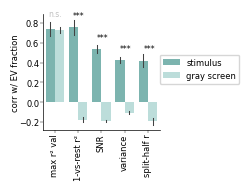

In [42]:
import matplotlib.pyplot as plt
x='Value_Type'
y='corr'
hue='Activity Type'

figsize=(1.5,1.5)
order= df_mouse_corr.Value_Type.unique()[1:]
filter_bool = df_mouse_corr['relationship'].isin(['EV_EV'])
area_bool = df_mouse_corr['Area']=='L2/3'
mask = (~filter_bool)&area_bool
palette=['#72BEB7','#B6E3DF']
hue_order= ['stimulus','gray screen']

fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=df_mouse_corr[mask], x=x, palette=palette,
            y=y, order=order, hue=hue, hue_order=hue_order,
            errorbar='se', err_kws={'linewidth': 0.75})
set_corr_figs_params(ax, fontsize=6)
ax.legend(loc=(1,0.4), fontsize=6)
add_stars_5_sets(df_mouse_corr[mask], neuron_property=y, x=x,x_order=order, hue=hue, ax=ax, heights=[0.99,0.99,0.8,0.7,0.7], fontsize=5.5)


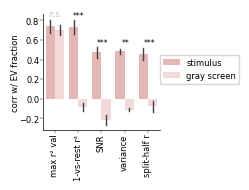

In [41]:
area_bool = df_mouse_corr['Area']=='L4'
mask = (~filter_bool)&area_bool
palette=['#EDAEAE', '#f6d6d6']
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=df_mouse_corr[mask], x='Value_Type', palette=palette,
            y='corr', order=order, hue='Activity Type', hue_order=hue_order,
             errorbar='se', err_kws={'linewidth': 1})
set_corr_figs_params(ax, fontsize=6)
sns.despine()
ax.legend(loc=(1,0.4), fontsize=6)
add_stars_5_sets(df_mouse_corr[mask], neuron_property=y, x=x, x_order=order, hue=hue, ax=ax,heights=[0.99,0.99,0.75,0.75,0.75], fontsize=5.5)

In [384]:

df_mouse_both=pd.merge(df_mouse[df_mouse['Activity Type']=='stimulus'],df_mouse[df_mouse['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²',
       'variance', 'control_shuffle','Neuron'])

In [385]:
df_mouse_removed_pcs_= make_mouse_df_neuron_properties(mouse_stats , dataset_types=['ori32','natimg32','ori32_spont','natimg32_spont'], remove_pcs=True)
df_mouse_removed_pcs=df_mouse_removed_pcs_[df_mouse_removed_pcs_['control_shuffle']==False]
df_mouse_removed_pcs_corr = make_corr_df_mouse(mouse_stats, df_mouse_removed_pcs)
df_mouse_removed_pcs_both=pd.merge(df_mouse_removed_pcs[df_mouse_removed_pcs['Activity Type']=='stimulus'],df_mouse_removed_pcs[df_mouse_removed_pcs['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²',
       'variance', 'control_shuffle','Neuron'])

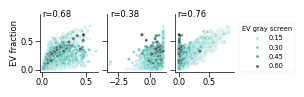

In [283]:
neuron_properties = ['max r² val', 'split-half r', '1-vs-rest r²', ]
area='L2/3'
df_filtered_mouse=df_mouse_both.sample(8000, random_state=17)
df_filtered_mouse_removed=df_mouse_removed_pcs_both.sample(8000, random_state=17)
df_filtered_mouse_sorted = df_filtered_mouse.sort_values('EV gray screen')

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_mouse(df_filtered_mouse_sorted,area, neuron_property, ax,  markersize=5,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, legend=True)
    ax.set_ylim(top=max(df_filtered_mouse_sorted[df_filtered_mouse_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed[df_filtered_mouse_removed.Area==area]['EV'].max()) +0.05)
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
axes[2].set_xlim(left=df_filtered_mouse['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse['1-vs-rest r²'].max()+0.07)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

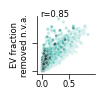

In [282]:

area='L2/3'
df_filtered_mouse_removed=df_mouse_removed_pcs_both.sample(8000, random_state=17)
df_filtered_mouse_removed_sorted = df_filtered_mouse_removed.sort_values('EV gray screen')
hspace=0.3
wspace=0.15
figsize=(0.75,0.75)
fig, ax = plt.subplots(figsize=figsize)

corr = plot_mouse(df_filtered_mouse_removed_sorted,area, neuron_property, ax, markersize=5,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, r_pos=(0.05,0.99), legend=False)
ax.set_ylim(top=max(df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max()) +0.05)
ax.set_yticks([0,0.5])
ax.set(xlim=(-0.1,1))
ax.set_ylabel('EV fraction\nremoved n.v.a.', fontsize=6, labelpad=1)
ax.set_xlabel(None)
ax.set_yticklabels('')
ax.set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)
axes[2].set_xlim(left=df_filtered_mouse_removed['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse_removed['1-vs-rest r²'].max()+0.07)
plt.show()


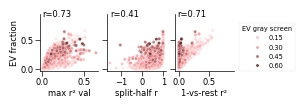

In [284]:
area='L4'
figsize=(2.5,0.75)
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_mouse(df_filtered_mouse_sorted,area, neuron_property, ax, markersize=5, 
                     alpha=0.8, hue='EV gray screen', palette=v1_cmap)
    ax.set_ylim(top=max(df_filtered_mouse_sorted[df_filtered_mouse_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed[df_filtered_mouse_removed.Area==area]['EV'].max()) +0.05)
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    ax.set_xlabel(neuron_property,labelpad=1)
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)

axes[2].set_xlim(left=df_filtered_mouse['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse['1-vs-rest r²'].max()+0.07)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

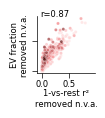

In [286]:

area='L4'
fontsize=6
figsize=(0.75,0.75)
fig, ax = plt.subplots(figsize=figsize)
corr = plot_mouse(df_filtered_mouse_removed_sorted,area, neuron_property, ax, 
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5, r_pos=(0.05,0.99))
ax.set_ylim(top=max(df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max(),df_filtered_mouse_removed_sorted[df_filtered_mouse_removed_sorted.Area==area]['EV'].max()) +0.05)
ax.set_yticks([0,0.5])
ax.set(xlim=(-0.1,1))
ax.set_ylabel('EV fraction\nremoved n.v.a.', fontsize=fontsize, labelpad=1)
ax.set_xlabel('1-vs-rest r²\nremoved n.v.a.', fontsize=fontsize,labelpad=0)
ax.legend_.remove()
ax.set_yticklabels('')
ax.set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)
axes[2].set_xlim(left=df_filtered_mouse_removed_sorted['1-vs-rest r²'].min()-0.07, right=df_filtered_mouse_removed_sorted['1-vs-rest r²'].max()+0.07)
plt.show()

In [274]:
def add_ax_properties_corr(ax, df_mouse_both, neuron_property):
    ax.set_ylim(top=df_mouse_both['EV'].max())
    ax.set_xlim(right=df_mouse_both[neuron_property].max())
    ax.set_yticks([0,0.5])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
    ax.set_xticks([0,0.5])

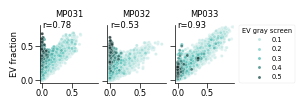

In [275]:
neuron_property = '1-vs-rest r²'
area='L2/3'

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_both[df_mouse_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax,
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_both, neuron_property)
    ax.set_title(mouse_name, fontsize=6)
plt.subplots_adjust(hspace=hspace, wspace=wspace)



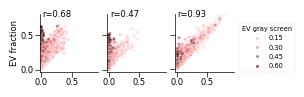

In [276]:
neuron_property = '1-vs-rest r²'
area='L4'

fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_both[df_mouse_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, 
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_both, neuron_property)
plt.subplots_adjust(hspace=hspace, wspace=wspace)



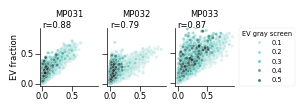

In [280]:
neuron_property = '1-vs-rest r²'
area='L2/3'

figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_removed_pcs_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_removed_pcs_both[df_mouse_removed_pcs_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, r_pos= (0.05, 1),
                    alpha=0.8, hue='EV gray screen', palette=v4_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_removed_pcs_both, neuron_property)
    ax.set_title(mouse_name, fontsize=6, y=1.05)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

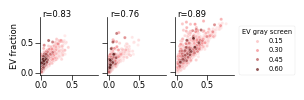

In [281]:

area='L4'
fig, axes = plt.subplots(1, 3, figsize=figsize)
mouse_names = df_mouse_removed_pcs_both['Mouse Name'].unique()
for a, (ax, mouse_name) in  enumerate(zip(axes.flatten(), mouse_names)):
    mini_mouse_df = df_mouse_removed_pcs_both[df_mouse_removed_pcs_both['Mouse Name']==mouse_name].reset_index()
    mini_mouse_df_sorted = mini_mouse_df.sort_values('EV gray screen')
    corr = plot_mouse(mini_mouse_df_sorted,area, neuron_property, ax, r_pos= (0.05, 1),
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap, markersize=5)
    add_ax_properties_corr(ax, df_mouse_removed_pcs_both, neuron_property)
plt.subplots_adjust(hspace=hspace, wspace=wspace)

### supplemental

In [386]:
df_mouse_both_nonan= df_mouse_both.dropna().reset_index()
df_mouse_removed_pcs_both_nonan= df_mouse_removed_pcs_both.dropna().reset_index()
df_mouse_both= df_mouse_both_nonan[df_mouse_both_nonan['EV gray screen'].isin(df_mouse_removed_pcs_both_nonan['EV gray screen'])]
df_mouse_removed_pcs_both = df_mouse_removed_pcs_both_nonan[df_mouse_removed_pcs_both_nonan['EV gray screen'].isin(df_mouse_both_nonan['EV gray screen'])]

In [389]:
df_mouse_both['removed\nspont. act.']=False
df_mouse_removed_pcs_both['removed\nspont. act.']=True
df_both_comparison = pd.concat([df_mouse_both, df_mouse_removed_pcs_both])

df_both_comparison_visual = pd.concat([df_mouse_both[(df_mouse_both.SNR>2)&(df_mouse_both['split-half r']>0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR>2)&(df_mouse_both['split-half r']>0.8)]])
df_both_comparison_nonvisual = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)&(df_mouse_both['split-half r']<0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)&(df_mouse_both['split-half r']<0.8)]])
df_both_comparison_mediumvisual = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)|(df_mouse_both['split-half r']<0.8)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)|(df_mouse_both['split-half r']<0.8)]])
df_both_comparison_low_SNR = pd.concat([df_mouse_both[(df_mouse_both.SNR<2)],df_mouse_removed_pcs_both[(df_mouse_both.SNR<2)]])
df_both_comparison_high_SNR = pd.concat([df_mouse_both[(df_mouse_both.SNR>2)],df_mouse_removed_pcs_both[(df_mouse_both.SNR>2)]])

trad_threshold = 0.9
df_both_comparison_high_trad_reli = pd.concat([df_mouse_both[(df_mouse_both['split-half r']>trad_threshold)],df_mouse_removed_pcs_both[(df_mouse_both['split-half r']>trad_threshold)]])
df_both_comparison_low_trad_reli = pd.concat([df_mouse_both[(df_mouse_both['split-half r']<trad_threshold)],df_mouse_removed_pcs_both[(df_mouse_both['split-half r']<trad_threshold)]])

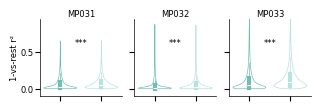

In [380]:
neuron_property = '1-vs-rest r²'
area='L2/3'
x = 'removed\nspont. act.'
hue='removed\nspont. act.'
sample_size=20
seed=17
fontsize=6
figsize=(3.5,1)
stars_height=0.7
fig, axes = plt.subplots(1, 3, figsize=figsize)
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes,sample_size=sample_size, 
                neuron_property_label='1-vs-rest r²',neuron_labels = ['r>mean','r<mean'],
                    legend=False, show_lineplot=False, height=stars_height)
[axes[a].set_xticklabels([]) for a in range(3)]
plt.show()

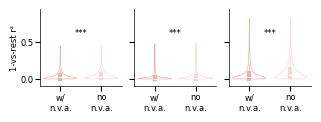

In [381]:
area='L4'
sample_size=20
seed=17
stars_height=0.7
fig, axes = plt.subplots(1, 3, figsize=figsize)
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes,sample_size=sample_size, 
                neuron_property_label='1-vs-rest r²',neuron_labels = ['r>mean','r<mean'],
                    legend=False, show_lineplot=False, height=stars_height)
[axes[a].set_title(None) for a in range(3)]
plt.show()

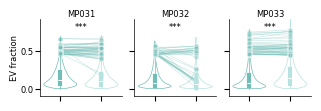

In [390]:
neuron_property = 'EV'
area='L2/3'
sample_size=25
seed=17
fontsize=6
fig, axes = plt.subplots(1, 3, figsize=figsize)
threshold=0.45
height=0.9
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes, threshold=threshold,sample_size=sample_size,
                neuron_property_label='EV fraction',neuron_labels = [f'EV>{threshold}',f'EV<{threshold}'],height=height,
                    legend=False, filter_only_high_neurons=True)
[axes[a].set_xticklabels([]) for a in range(3)]
plt.show()

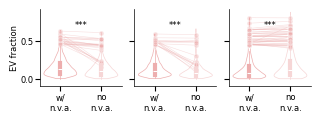

In [391]:
neuron_property = 'EV'
area='L4'
sample_size=25
seed=17
fontsize=6
fig, axes = plt.subplots(1, 3, figsize=figsize)
threshold=0.45
height=0.8
plot_spont_figs(df_both_comparison, area, neuron_property, x, hue, axes, threshold=threshold,sample_size=sample_size,
                neuron_property_label='EV fraction',neuron_labels = [f'EV>{threshold}',f'EV<{threshold}'],height=height,
                    legend=False, filter_only_high_neurons=True)
[axes[a].set_title(None) for a in range(3)]
plt.show()

## Monkey neuron properties

In [ ]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

### plotting

In [153]:
df_monkey_ = make_monkey_df_neuron_properties(monkey_stats, dataset_types=list(monkey_stats.keys()))
df_monkey = df_monkey_[df_monkey_.control_shuffle==False]
df_monkey_corr=make_corr_df_monkey(monkey_stats, df_monkey)

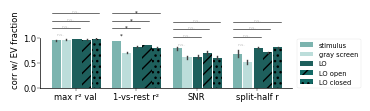

In [166]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(3.25,0.65))
mask, order = plot_corr_bars(df_monkey_corr, ax, area='V4')
star1_positions = np.array([0.08,0.1,0.12,0.14])
star2_positions = star1_positions+ 0.24
star3_positions = star2_positions+ 0.24
star4_positions = star3_positions+ 0.24
x_position_left=-0.395
x_positions_right=np.array([0.07,0.21,0.39])

bar_star_height1 = 1.2
spacing = 0.15
bar_star_heights = np.array([bar_star_height1 + n*spacing for n in range(3)])
bar_heights = bar_star_heights-0.01

add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[0], height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star1_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left, x_positions_right)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[1],height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star2_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left+1, x_positions_right+1)
bar_star_heights=bar_star_heights - 0.17
bar_heights = bar_star_heights-0.01
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[2], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star3_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+2, x_positions_right+2)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[3], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star4_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+3, x_positions_right+3)
# ax.set_xticks([])
ax.set_ylim(top=1)


hatch_size=3
handles, labels = ax.get_legend_handles_labels()
legend_colors=['#72BEB7','#B6E3DF','#136a66','#136a66','#136a66']
legend = ax.legend(loc=(1.02,0), fontsize=6*0.8, handles=[handles[0],handles[1], handles[2],Patch(hatch='/' * hatch_size, label=labels[3], facecolor=legend_colors[3]),
                                              Patch(hatch='.' * hatch_size, label=labels[4], facecolor=legend_colors[4])],
        labels=['stimulus', 'gray screen','LO','LO open','LO closed'])
legend.set_title(None)
legend.get_frame().set_linewidth(0.2)
plt.show()


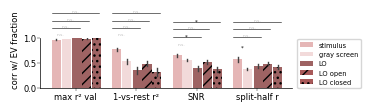

In [167]:
fig, ax = plt.subplots(figsize=(3.25,0.65))
mask, order = plot_corr_bars(df_monkey_corr, ax, area='V1')
star1_positions = np.array([0.08,0.1,0.12,0.14])
star2_positions = star1_positions+ 0.24
star3_positions = star2_positions+ 0.24
star4_positions = star3_positions+ 0.24
x_position_left=-0.395
x_positions_right=np.array([0.07,0.21,0.39])

bar_star_height1 = 1.2
spacing = 0.15
bar_star_heights = np.array([bar_star_height1 + n*spacing for n in range(3)])
bar_heights = bar_star_heights-0.01

add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[0], height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star1_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left, x_positions_right)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[1],height1=1.05,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star2_positions,show_bar=False)
plot_bars(ax, bar_heights,x_position_left+1, x_positions_right+1)
bar_star_heights=bar_star_heights - 0.17
bar_heights = bar_star_heights-0.01
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[2], height1=0.85,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star3_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+2, x_positions_right+2)
add_anova_stars_1_set(df_monkey_corr[mask], 'corr', x='Value_Type', x1=order[3], height1=0.8,height2=bar_star_heights[0],height3=bar_star_heights[1], height4=bar_star_heights[2],
hue='Activity Type', ax=ax, fontsize=4, stars1_positions=star4_positions, show_bar=False)
plot_bars(ax, bar_heights,x_position_left+3, x_positions_right+3)
ax.set_ylim(top=1)

hatch_size=3
handles, labels = ax.get_legend_handles_labels()
legend_colors=['#EDAEAE', '#f6d6d6','#a85959','#a85959','#a85959']
legend = ax.legend(loc=(1.02,0), fontsize=6*0.8, handles=[handles[0],handles[1], handles[2],Patch(hatch='/' * hatch_size, label=labels[3], facecolor=legend_colors[3]),
                                              Patch(hatch='.' * hatch_size, label=labels[4], facecolor=legend_colors[4])],
        labels=['stimulus', 'gray screen','LO','LO open','LO closed'])

plt.show()

In [170]:
df_monkey_both=pd.merge(df_monkey[df_monkey['Activity Type']=='stimulus'],df_monkey[df_monkey['Activity Type']=='gray screen'].rename(columns={'EV':'EV gray screen','max r² val':'max r² val gray screen'}), on=['Date', 'Area',
       'Direction', 'SNR', 'split-half r', '1-vs-rest r²','control_shuffle'])
df_monkey_both_sorted = df_monkey_both.sort_values('EV gray screen')

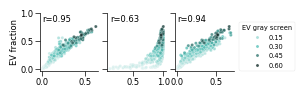

In [172]:
neuron_properties = ['max r² val', 'split-half r','1-vs-rest r²']
area='V4'
figsize=(2.5,0.75)
hspace=0.3
wspace=0.15
fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_date(df_monkey_both_sorted,area, neuron_property, ax, r_loc=(0.05,0.85),s=5,
                     alpha=0.8, hue='EV gray screen', palette=v4_cmap)
    ax.set_ylim(top=1)
    ax.set_yticks([0,0.5,1])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    if a!=2:
        ax.legend_.remove()
    else:
        legend = ax.legend(loc=(1.1,0),fontsize=6*0.8)
        legend.set_title(title='EV gray screen',prop={'size':6*0.8})
        legend.get_frame().set_linewidth(0.2)
    ax.set_xlabel(None)
axes[0].set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)

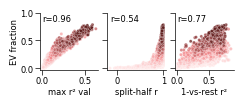

In [173]:
area='V1'

fig, axes = plt.subplots(1, 3, figsize=figsize)
for a, (ax, neuron_property) in  enumerate(zip(axes.flatten(), neuron_properties)):
    corr = plot_date(df_monkey_both_sorted,area, neuron_property, ax, r_loc=(0.05,0.85),s=5,
                    alpha=0.8, hue='EV gray screen', palette=v1_cmap)
    ax.set_ylim(top=1)
    ax.set_yticks([0,0.5,1])
    if a==0 or a==3:
        ax.set_ylabel('EV fraction', fontsize=6, labelpad=1)
    else: 
        ax.set_yticklabels('')
        ax.set(ylabel='')
    ax.legend_.remove()
    
axes[0].set_xticks(ticks=[0,0.5])
plt.subplots_adjust(hspace=hspace, wspace=wspace)

## Monkey RF overlap

In [ ]:
import time
from macaque_data_functions import get_get_condition_type

all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                    'RS_open':20, 'RS_closed': 20, 
                    'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_open':None, 'RS_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

start_time = time.time()
get_electrode_ids_all_dates(monkey_stats)

ref_area='V4'
condition_types = ['SNR','SNR_spont','RF_thin', 'RF_large', 'RS']
w_size=25
n_splits=10

percent_over=80
percent_under=10
target_x_n=14

for condition_type in condition_types:
    get_predictor_indices_elec_ids(monkey_stats, condition_type, get_get_condition_type(condition_type), target_x_n, percent_over, percent_under)
    get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_predictor_RF_sizes(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=False)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')


In [ ]:
ref_area='V1'
for condition_type in condition_types:
    get_predictor_inndices_elec_ids(monkey_stats, condition_type, get_get_condition_type(condition_type), target_x_n, percent_over, percent_under)
    get_xtarget_predictor_indices_elecs(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_predictor_RF_sizes(mokey_stats, condition_type, get_get_condition_type(condition_type), seeds, ref_area, target_x_n, percent_over, percent_under)
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=False)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

In [ ]:
## shuffle control

ref_area='V4'
for condition_type in condition_types:
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=True)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

In [ ]:
ref_area='V1'
for condition_type in condition_types:
    get_x_target_overlap_evars(monkey_stats, condition_type, get_get_condition_type(condition_type), seeds, 
                            ref_area, target_x_n=target_x_n, percent_over=percent_over, 
                            percent_under=percent_under, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], 
                            frames_to_reduce=all_frames_reduced[condition_type], n_splits=n_splits, 
                            control_shuffle=True)
    print(condition_type, 'done')
end_time = time.time()
elapsed_time = (end_time - start_time)/60

print(f'yay! RF overlap evar comparisons for area {ref_area} is now completed')
print(f'Took {elapsed_time:.4f} minutes to complete')

### plotting

In [246]:
percent_over=80
percent_under=10
target_x_n=14
df_all = pd.DataFrame([])
condition_types=['SNR', 'SNR_spont','RS','RF_thin','RF_large']
for condition_type in condition_types:
    df_all=pd.concat([df_all,create_df_overlaps(monkey_stats, condition_type, target_x_n, percent_over, percent_under)])
df = df_all[df_all.control_shuffle==False]
df_filtered_all= df_all.groupby(['Activity_Type','Condition_Type','Date', 'Area', 'trad_reli','SNR', 'normal_EV', 'overlap_type', 'Pred_Type', 'target_elec_id','control_shuffle']).agg({'EV':'mean'}).reset_index()
df_filtered_ = df_filtered_all[df_filtered_all.control_shuffle==False]

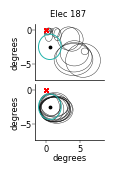

In [228]:
condition_type = 'SNR'
date='090817'
refelec=187
fig, axes= plt.subplots(2,1, figsize=(1,1.5))
plot_cell_rf_overlaps(df_=df, refelec=refelec, condition_type=condition_type, date=date, axes=axes)
plt.subplots_adjust(hspace=0.08)

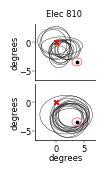

In [234]:
condition_type = 'SNR'
date='090817'
refelec=810
fig, axes= plt.subplots(2,1, figsize=(1,1.5))
plot_cell_rf_overlaps(df_=df, refelec=refelec, condition_type=condition_type, date=date, axes=axes)
plt.subplots_adjust(hspace=0.08)

In [267]:
def plot_rf_overlap_performance(df_filtered_all, area, **args):
    df_filtered=df_filtered_all[(df_filtered_all['SNR']>2) & (df_filtered_all['trad_reli']>0.8)&(df_filtered_all.control_shuffle==False)]
    df_filtered_control = df_filtered_all[(df_filtered_all['SNR']>2) & (df_filtered_all['trad_reli']>0.8)&(df_filtered_all.control_shuffle==True)]
    fig, ax =plt.subplots(figsize=(2,1.5))
    if area=='V4':
        palette=['#B6E3DF','#72BEB7','#136a66']
    else:
        palette=[ '#f6d6d6','#EDAEAE','#a85959']
    
    sns.violinplot(df_filtered[df_filtered.Area==area], y='EV', x='Activity_Type', hue='overlap_type', 
                    order=['image','SNR_spont','RS'],
                hue_order= ['<10%', '>80%','all'], palette=palette,
                linewidth=0, width=0.8, inner='box',
                inner_kws={'box_width':1.25, 'color':'#191919'},cut=0,**args
                )
    legend = ax.legend(fontsize=6*0.8, loc=(1.01,0.5))
    legend.set_title(title='overlap type',prop={'size':6*0.8})
    legend.get_frame().set_linewidth(0.2)
    
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks=ax.get_xticks(), labels=['image', 'gray\nscreen', 'lights\noff'])
    ax.tick_params(axis='both', labelsize=6, width=0.5)
    ax.set(xlabel=None)
    ax.set_ylabel('EV fraction', fontsize=6)

    stars1_positions= [0.12,0.17,0.22]
    stars2_positions= [0.45,0.5,0.55]
    stars3_positions= [0.8,0.85,0.89]

    heights=[0.82,0.89,0.82]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[0], hue='overlap_type', ax=ax, 
                            fontsize=5, perm_t=True, stars1_positions=stars1_positions, bar_halflength = 0.1, height1=heights[0],height2=heights[1],height3=heights[2])
    heights=[0.62,0.69,0.62]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[1], hue='overlap_type', ax=ax, 
                            fontsize=5,  perm_t=True, stars1_positions=stars2_positions,bar_halflength = 0.1,height1=heights[0],height2=heights[1],height3=heights[2] )
    heights=[0.85,0.92,0.85]
    add_anova_stars_1_set_rf_overlap(df_filtered[df_filtered.Area==area], neuron_property='EV',x='Activity_Type',x1=xtick_labels[2], hue='overlap_type', ax=ax, 
                            fontsize=5, perm_t=True, stars1_positions=stars3_positions, bar_halflength = 0.1,height1=heights[0],height2=heights[1],height3=heights[2])

    ax.spines[:].set_linewidth(0.5)
    sns.despine()

    plot_null_line(df_filtered_control[df_filtered_control.Area==area], neuron_property='EV', ax=ax)

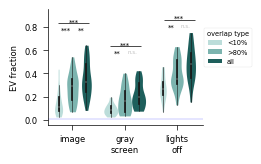

In [268]:
area='V4'
plot_rf_overlap_performance(df_filtered_all, area)

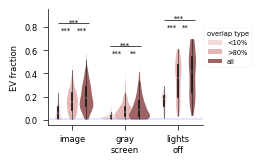

In [269]:
area='V1'
plot_rf_overlap_performance(df_filtered_all, area, gap=-0.5)